In [208]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
import numpy as np
import random
import time

np_config.enable_numpy_behavior()

In [209]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [168]:
activation_functions = {
    'tanh': tf.tanh,
    'relu': tf.nn.relu,
    'sigmoid': tf.nn.sigmoid,
    'linear': tf.keras.activations.linear,
    'softmax': tf.nn.softmax,
    'sign': tf.sign,
    'sin': tf.sin,
    'exp': tf.exp
}

**Loading Data**

In [169]:
SUBSET = 1.0    # subset of X_test used during training

In [170]:
%%time

# numpy
_, (X_test, y_test) = mnist.load_data() # only care  about X_test

selection = np.random.choice(np.arange(X_test.shape[0]),
                             int(SUBSET * X_test.shape[0]),
                             replace=False)

y_test = to_categorical(y_test[selection])  # one-hot encoding
y_true = np.argmax(y_test, axis=1)  # store for faster evaluation

# tensorflow
X_test = tf.convert_to_tensor(X_test[selection].astype(np.float32) / 255.0)
X_test = tf.reshape(X_test, shape=(X_test.shape[0],
                                   X_test.shape[1],
                                   X_test.shape[2],
                                   1))
y_test = tf.convert_to_tensor(np.transpose(y_test))

CPU times: total: 234 ms
Wall time: 231 ms


**Network Definition**

**TODO: BIAS AND ACTIVATION FUNCTION TO CONV**

In [171]:
MUTATE_RATE_MATRIX = None               # init later
MUTATE_RATE_BIAS = None                 # init later
MUTATE_RATE_ACTIVATION_FUNCTION = None  # init later
MUTATE_RATE_KERNEL = None               # init later
CROSSOVER_RATE = None                   # init later
GAUSSIAN_NOISE_STDDEV = None            # init later
UNIFORM_CROSSOVER = None                # init later

CONV_FILTER_SHAPE = None    # init later
FILTER_STRIDES = None       # init later
POOLING_STRIDES = None      # init later

In [172]:
def dimensions_in_conv_layers(*filters):
    """
    Gets dimensions before and after each convolutional (with pooling) layer
    :param filters: filter in convolutional layer
    :param conv_strides: for each layer, filter strides - array
    :return: list of dimensions (input_shape, output_shape)
    """
    x = X_test[0:2, :, :, :]
    batch_size, height, width, channels = x.shape
    dimensions = [(height, width, channels)]

    # convolutional layers
    for filter, filter_stride, pooling_stride in zip(filters, FILTER_STRIDES, POOLING_STRIDES):
        x = tf.nn.conv2d(x, filter, strides=[1, filter_stride, filter_stride, 1], padding='VALID')
        if pooling_stride != 0:
            x = tf.nn.max_pool2d(x, ksize=(2, 2), strides=(pooling_stride, pooling_stride), padding='VALID')
        batch_size, height, width, channels = x.shape
        dimensions.append((height, width, channels))

    # flatten
    x = tf.reshape(x, shape=(2, x.shape[-1] * x.shape[-2] * x.shape[-3]))
    dimensions.append(x.shape[-1])
    return dimensions

In [173]:
class CNN(Model):
    def __init__(self, **params):
        """
        Convolutional neural network
        :param params: matrix1, bias1, activation1, kernel1, etc.
        """
        super(CNN, self).__init__()

        self.conv_layers = max([int(param_name[-1]) if param_name[:-1] == 'kernel' else 0
                                for param_name in params.keys()])
        self.dense_layers = max([int(param_name[-1]) if param_name[:-1] == 'matrix' else 0
                                 for param_name in params.keys()])   # = number of hidden layers + 1 (output layer)

        for (param_name, param) in params.items():
            assert param_name[:-1] in ('matrix', 'bias', 'activation', 'kernel'), 'Invalid attribute!'
            setattr(self, param_name, param)

    def call(self, inputs):
        x = inputs

        for layer in range(1, self.conv_layers + 1):
            filter = getattr(self, 'kernel' + str(layer))
            filter_stride = FILTER_STRIDES[layer - 1]
            pooling_stride = POOLING_STRIDES[layer - 1]

            # convolution
            x = tf.nn.conv2d(x, filter,
                             strides=[1, filter_stride, filter_stride, 1],
                             padding='VALID')
            # pooling
            if pooling_stride != 0:
                x = tf.nn.max_pool2d(x, ksize=(2, 2), strides=(pooling_stride, pooling_stride), padding='VALID')
            # activation function # TODO: make mutable + bias
            x = activation_functions['relu'](x)

        # flatten
        x = tf.reshape(x, shape=(inputs.shape[0], x.shape[-1] * x.shape[-2] * x.shape[-3]))

        # fully connected layers
        for layer in range(1, self.dense_layers + 1):
            x @= getattr(self, 'matrix' + str(layer))
            x += getattr(self, 'bias' + str(layer))
            x = activation_functions[getattr(self, 'activation' + str(layer))](x) if layer != self.dense_layers else x

        return x

    def evaluate(self, mini_batch=1.0):
        if mini_batch < 1.0:
            selection = np.random.choice(np.arange(X_test.shape[0]),
                                         int(mini_batch * X_test.shape[0]),
                                         replace=False)
            y_pred = np.argmax(self.call(X_test[selection]), axis=1)
            return np.mean(y_pred == y_true[selection])
        else:
            y_pred = np.argmax(self.call(X_test), axis=1)
            return np.mean(y_pred == y_true)

    def mutate(self):
        # convolutional layers
        for layer in range(1, self.conv_layers + 1):
            # kernel
            kernel = getattr(self, 'kernel' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_KERNEL, MUTATE_RATE_KERNEL]]),
                kernel.shape[0] * kernel.shape[1] * kernel.shape[2] * kernel.shape[3]), kernel.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=kernel.shape)
            kernel = kernel + tf.multiply(mutation_stencil, noise)
            setattr(self, 'kernel' + str(layer), kernel)

        # fully connected layers
        for layer in range(1, self.dense_layers + 1):
            # matrix
            matrix = getattr(self, 'matrix' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, 'matrix' + str(layer), matrix)

            # bias
            bias = getattr(self, 'bias' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[1]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, 'bias' + str(layer), bias)

            # activation
            if layer != self.dense_layers:
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                activation = cleaner(getattr(self, 'activation' + str(layer)))
                if random.uniform(0, 1) < MUTATE_RATE_ACTIVATION_FUNCTION:
                    activation = random.choice(list(activation_functions.keys()))
                setattr(self, 'activation' + str(layer), activation)

    def summary(self):
        dash = '-' * 90
        ddash = '=' * 90
        print(dash)
        print('Model')
        print(ddash)

        n_params = 0

        # convolutional layers
        conv_IO = dimensions_in_conv_layers(*[getattr(self, 'kernel' + str(layer)) for layer in range(1, self.conv_layers + 1)])
        for layer in range(1, self.conv_layers + 1):
            # get values
            kernel = getattr(self, 'kernel' + str(layer))

            n_params += kernel.shape[0] * kernel.shape[1] * kernel.shape[2] * kernel.shape[3]
            height_curr, width_curr, channels_curr = conv_IO[layer - 1]
            height_next, width_next, channels_next = conv_IO[layer]

            # print adjustments
            layer_IO = '(in={}, out={})'.format((height_curr, width_curr, channels_curr), (height_next, width_next, channels_next))
            pool = '' if POOLING_STRIDES[layer - 1] == 0 else '+ Pooling'
            layer = 'Convolution {} {}'.format('(relu)', pool)

            print('{:<30} {:<40} #Params: {}'.format(layer, layer_IO, kernel.shape[0] * kernel.shape[1] * kernel.shape[2] * kernel.shape[3]))

        # flatten
        height, width, channels = conv_IO[self.conv_layers]
        layer_IO = '(in={}, out={})'.format((height, width, channels), (height * width * channels))
        layer = 'Flatten ()'
        print('{:<30} {:<40} #Params: {}'.format(layer, layer_IO, 0))

        # fully connected layers
        for layer in range(1, self.dense_layers + 1):
            # get values
            matrix = getattr(self, 'matrix' + str(layer))
            bias = getattr(self, 'bias' + str(layer))
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))


            n_params += matrix.shape[0] * matrix.shape[1] + bias.shape[0] * bias.shape[1] + 1

            # print adjustments
            activation = '({})'.format(activation)
            layer_IO = '(in={}, out={})'.format(matrix.shape[0], matrix.shape[1],)
            layer = 'Linear {}'.format(activation)

            print('{:<30} {:<40} #Params: {}'.format(layer, layer_IO, matrix.shape[0] * matrix.shape[1] + bias.shape[0] * bias.shape[1] + 1))

        print(ddash)
        print('Total params: {}'.format(n_params))
        print('Accuracy: {}\n'.format(round(self.evaluate(), 3)))

In [182]:
class Population:
    def __init__(self, size=10, n_survivors=5):
        """
        :param size: population size
        :param n_survivors: number of survivors after each generation (rest is killed and unable to pass on its genes)
        :param n_hidden_layers: number of hidden layers
        """
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.elite = None
        self.fitness = None # cache fitness for increased speed
        self.fitness_generation = -1  # generation when fitness was evaluated
        self.mini_batch = 1.0

        # initialization (gaussian)
        self.organisms = []
        for _ in range(size):
            params = {}

            # convolutional layers
            in_channels = X_test.shape[-1]
            for layer in range(1, len(CONV_FILTER_SHAPE) + 1):
                # filter shape: [filter_height, filter_width, in_channels, out_channels=n_filters]
                filter_size = CONV_FILTER_SHAPE[layer - 1]
                params['kernel' + str(layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[filter_size[0],
                                                                                              filter_size[1],
                                                                                              in_channels,
                                                                                              filter_size[2]])
                in_channels = filter_size[2]

            # fully connected layers
            n_neurons_prev = dimensions_in_conv_layers(*list(params.values()))[-1]
            n_neurons_curr = HIDDEN_LAYER_WIDTH[0]
            activation = 'sigmoid'
            for layer in range(1, N_HIDDEN_LAYERS + 2): # output layer
                # output layer
                if layer == N_HIDDEN_LAYERS + 1:
                    n_neurons_curr = y_test.shape[0]
                    activation = 'softmax'  # otherwise performance can decrease significantly (e.g. overflow)
                else:
                    n_neurons_curr = HIDDEN_LAYER_WIDTH[layer - 1]
                params['matrix' + str(layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[n_neurons_prev, n_neurons_curr])
                params['bias' + str(layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[1, n_neurons_curr])
                params['activation' + str(layer)] = activation
                n_neurons_prev = n_neurons_curr

            model = CNN(**params)
            self.organisms.append(model)

        self.history = {'max': [self.max_fitness()],
                        'min': [self.min_fitness()],
                        'avg': [self.average_fitness()]} # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate(mini_batch=self.mini_batch) for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def min_fitness(self):
        return min(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        children = []
        while len(children) < int(CROSSOVER_RATE * (self.size - 1)):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            child_params = {}

            # convolutional layers
            for layer in range(1, father.conv_layers + 1):
                if UNIFORM_CROSSOVER:
                    # kernel - uniform crossover
                    father_kernel = getattr(father, 'kernel' + str(layer))
                    mother_kernel = getattr(mother, 'kernel' + str(layer))

                    father_mask = tf.round(tf.random.uniform(father_kernel.shape))
                    mother_mask = - (father_mask - 1)

                    child_kernel = tf.multiply(father_mask, father_kernel) + tf.multiply(mother_mask, mother_kernel)
                    child_params['kernel' + str(layer)] = child_kernel
                else:
                    # kernel - filter-wise crossover
                    father_kernel = getattr(father, 'kernel' + str(layer))
                    mother_kernel = getattr(mother, 'kernel' + str(layer))

                    filter_height, filter_width, in_channels, n_filters = father_kernel.shape
                    father_mask = tf.zeros([filter_height, filter_width, in_channels, 1]) if random.uniform(0, 1) < 0.5 \
                        else tf.ones([filter_height, filter_width, in_channels, 1])
                    for _ in range(n_filters - 1):
                        filter_mask = tf.zeros([filter_height, filter_width, in_channels, 1]) if random.uniform(0, 1) < 0.5 \
                            else tf.ones([filter_height, filter_width, in_channels, 1])
                        father_mask = tf.concat([father_mask, filter_mask], axis=-1)

                    mother_mask = - (father_mask - 1)

                    child_kernel = tf.multiply(father_mask, father_kernel) + tf.multiply(mother_mask, mother_kernel)
                    child_params['kernel' + str(layer)] = child_kernel

                    child_params['kernel' + str(layer)] = child_kernel

            # fully connected layers
            for layer in range(1, father.dense_layers + 1):
                if UNIFORM_CROSSOVER:
                    # matrix - uniform crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    father_mask = tf.round(tf.random.uniform(father_matrix.shape))
                    mother_mask = - (father_mask - 1)

                    child_matrix = tf.multiply(father_mask, father_matrix) + tf.multiply(mother_mask, mother_matrix)
                    child_params['matrix' + str(layer)] = child_matrix
                else:
                    # matrix - column-wise (neuron-wise) crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    n_cols = father_matrix.shape[1]
                    child_matrix = father_matrix.numpy()
                    for col in range(n_cols):
                        coin_toss = np.random.choice([True, False])
                        if coin_toss:
                            child_matrix[:, col] = mother_matrix[:, col]

                    child_params['matrix' + str(layer)] = tf.convert_to_tensor(child_matrix)

                # bias - uniform crossover
                father_bias = getattr(father, 'bias' + str(layer))
                mother_bias = getattr(mother, 'bias' + str(layer))

                father_mask = tf.round(tf.random.uniform(father_bias.shape))
                mother_mask = - (father_mask - 1)

                child_bias = tf.multiply(father_mask, father_bias) + tf.multiply(mother_mask, mother_bias)
                child_params['bias' + str(layer)] = child_bias

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                father_activation = cleaner(getattr(father, 'activation' + str(layer)))
                mother_activation = cleaner(getattr(mother, 'activation' + str(layer)))

                child_activation = father_activation if (random.uniform(0, 1) < 0.5) else mother_activation
                child_params['activation' + str(layer)] = child_activation

            model = CNN(**child_params)
            children.append(model)

        # if CROSSOVER_RATE != 100% allow some individuals to pass on their genes without crossover
        while len(children) < (self.size - 1):
            [model] = random.sample(parents + [self.elite], k=1)  # sample without replacement

            child_params = {}

            # convolutional layers
            for layer in range(1, model.conv_layers + 1):
                # kernel
                child_params['kernel' + str(layer)] = tf.identity(getattr(model, 'kernel' + str(layer)))

            # fully connnected layers
            for layer in range(1, model.dense_layers + 1):
                # matrix
                child_params['matrix' + str(layer)] = tf.identity(getattr(model, 'matrix' + str(layer)))

                # bias
                child_params['bias' + str(layer)] = tf.identity(getattr(model, 'bias' + str(layer)))

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                child_params['activation' + str(layer)] = cleaner(getattr(model, 'activation' + str(layer)))

            model = CNN(**child_params)
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self, debug=False):
        if debug:
            time_debug = ''

            t_a = time.time()
            parents = self.selection()  # ~0.0005s
            t_b = time.time()
            time_debug += 'selection time: {}s - '.format(round(t_b - t_a, 4))

            t_a = time.time()
            children = self.crossover(parents)  # ~0.28s
            t_b = time.time()
            time_debug += 'crossover time: {}s - '.format(round(t_b - t_a, 4))

            t_a = time.time()
            self.mutate(children)  # ~0.15s#
            t_b = time.time()
            time_debug += 'mutation time: {}s - '.format(round(t_b - t_a, 4))

            print(time_debug)
        else:
            parents = self.selection()
            children = self.crossover(parents)
            self.mutate(children)

        self.organisms = children + [self.elite]
        self.generation += 1

        # store data
        max, min, avg = self.max_fitness(), self.min_fitness(), self.average_fitness()
        self.history['max'].append(max)
        self.history['min'].append(min)
        self.history['avg'].append(avg)

    def train(self, generations): # TODO: data storage vs self.history
        # current population
        print('Starting training')
        t_training = time.time()

        # evaluate initial population
        max, min, avg = self.max_fitness(), self.min_fitness(), self.average_fitness()
        t2 = time.time()

        print('Gen {} {:<3} avg: {:.3f} {:^3} max: {:.3f} ({:<3}s)'.format(
            self.generation, ':', round(avg, 3), '-', round(max, 3), round(t2 - t_training, 2)))

        # future populations
        for generation in range(1, generations):
            # breed new population
            t1 = time.time()
            self.breed()

            # evaluate new population
            max, min, avg = self.max_fitness(), self.min_fitness(), self.average_fitness()

            t2 = time.time()
            print('Gen {} {:<3} avg: {:.3f} {:^3} max: {:.3f} ({:<3}s)'.format(
                self.generation, ':', round(avg, 3), '-', round(max, 3), round(t2 - t1, 2)))

        print('Finished training ({})'.format(round(time.time() - t_training, 2)))

        # performance of population
        self.plot()
        plt.fill_between([i for i in range(len(self.history['max']))], self.history['max'], self.history['min'], color='orange', alpha=0.05)
        plt.show()

        # plot best performing final network
        organism_fitness = self.organism_fitness()
        elite_index = np.argmax(organism_fitness)
        self.organisms[elite_index].summary()

    def plot(self):
        # plot evolution
        plt.figure()
        plt.plot(np.arange(self.generation + 1), self.history['max'], label='max fitness')
        plt.plot(np.arange(self.generation + 1), self.history['avg'], label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()

**Training**

GA definition

In [183]:
global MUTATE_RATE_MATRIX
global MUTATE_RATE_BIAS
global MUTATE_RATE_ACTIVATION_FUNCTION
global MUTATE_RATE_KERNEL
global CROSSOVER_RATE
global GAUSSIAN_NOISE_STDDEV
global UNIFORM_CROSSOVER

MUTATE_RATE_MATRIX = 1.0
MUTATE_RATE_BIAS = 1.0
MUTATE_RATE_ACTIVATION_FUNCTION = 1.0
MUTATE_RATE_KERNEL = 1.0
CROSSOVER_RATE = 0.0
GAUSSIAN_NOISE_STDDEV = 0.5   # mutation applies additive gaussian noise
UNIFORM_CROSSOVER = False   # if True, performs crossover of matrices/filters element-wise, else neuron-wise/filter-wise

GENERATIONS = 1000
POPULATION_SIZE = 10
SURVIVORS = 1

Network definition

In [184]:
global CONV_FILTER_SHAPE
global FILTER_STRIDES
global POOLING_STRIDES

# convolutional layers
CONV_FILTER_SHAPE = [(3, 3, 6)]     # [(filter_height, filter_width, n_filters), ...]
FILTER_STRIDES = [1]
POOLING_STRIDES = [2]               # 0 means no pooling layer after conv

# fully connected layers
N_HIDDEN_LAYERS = 0                 # fully connected hidden layers
HIDDEN_LAYER_WIDTH = [64]

Run GA

Starting training
Gen 0 :   avg: 0.108  -  max: 0.149 (0.0s)
Gen 1 :   avg: 0.136  -  max: 0.194 (0.12s)
Gen 2 :   avg: 0.187  -  max: 0.224 (0.12s)
Gen 3 :   avg: 0.191  -  max: 0.224 (0.13s)
Gen 4 :   avg: 0.200  -  max: 0.224 (0.12s)
Gen 5 :   avg: 0.202  -  max: 0.224 (0.12s)
Gen 6 :   avg: 0.195  -  max: 0.237 (0.12s)
Gen 7 :   avg: 0.231  -  max: 0.254 (0.12s)
Gen 8 :   avg: 0.234  -  max: 0.260 (0.12s)
Gen 9 :   avg: 0.236  -  max: 0.260 (0.12s)
Gen 10 :   avg: 0.240  -  max: 0.282 (0.12s)
Gen 11 :   avg: 0.257  -  max: 0.288 (0.12s)
Gen 12 :   avg: 0.265  -  max: 0.288 (0.12s)
Gen 13 :   avg: 0.275  -  max: 0.304 (0.12s)
Gen 14 :   avg: 0.281  -  max: 0.310 (0.12s)
Gen 15 :   avg: 0.287  -  max: 0.323 (0.12s)
Gen 16 :   avg: 0.295  -  max: 0.333 (0.12s)
Gen 17 :   avg: 0.314  -  max: 0.345 (0.12s)
Gen 18 :   avg: 0.330  -  max: 0.345 (0.12s)
Gen 19 :   avg: 0.333  -  max: 0.355 (0.12s)
Gen 20 :   avg: 0.329  -  max: 0.355 (0.12s)
Gen 21 :   avg: 0.338  -  max: 0.368 (0.12s)
Gen

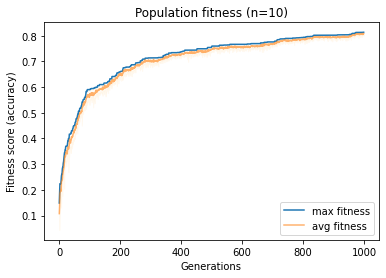

------------------------------------------------------------------------------------------
Model
Convolution (relu) + Pooling   (in=(28, 28, 1), out=(13, 13, 6))        #Params: 54
Flatten ()                     (in=(13, 13, 6), out=1014)               #Params: 0
Linear (softmax)               (in=1014, out=10)                        #Params: 10151
Total params: 10205
Accuracy: 0.813

CPU times: total: 1min 59s
Wall time: 1min 58s


In [185]:
%%time
# initial population
population = Population(size=POPULATION_SIZE,n_survivors=SURVIVORS)

# future populations
population.train(GENERATIONS)

**Plot confusion matrix**

Precision:
0 : 0.935 %
1 : 0.952 %
2 : 0.777 %
3 : 0.79 %
4 : 0.816 %
5 : 0.629 %
6 : 0.863 %
7 : 0.784 %
8 : 0.739 %
9 : 0.814 %


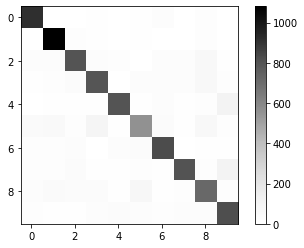

In [186]:
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(population.elite(X_test), axis=1))
plt.imshow(confusion_matrix, cmap='Greys')   # y-axis: y_true, x-axis: y_pred
plt.colorbar()
#print(confusion_matrix)

# precision for each class
print('Precision:')
precision = lambda row, i: round(row[i] / sum(row), 3)  # precision for each class
for i, row in enumerate(confusion_matrix.numpy()):
    print(i, ':', precision(row, i), '%')

**Plot filters**

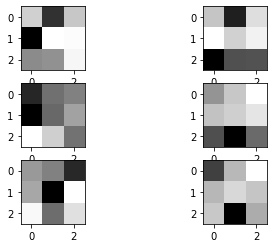

In [187]:
import math

filters = population.elite.kernel1
n_filters = filters.shape[-1]
plt.figure()
for filter_idx in range(n_filters):
    plt.subplot(math.ceil(n_filters**0.5), math.floor(n_filters**0.5), filter_idx + 1)
    plt.imshow(filters[:, :, :, filter_idx], cmap='Greys')